# EYE FOR BLIND

In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech.

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.

The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

In [1]:
#Import all the required libraries

import os
import glob as glob
import seaborn as sns
import numpy as np, pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

In [2]:
!pip install opendatasets --upgrade

  Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)
  Using cached kaggle-1.5.16-py3-none-any.whl
  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
## Library used to get the data from Kaggle to the current working directory

import opendatasets as od

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
## Importing the dataset to the current directory from Kaggle

od.download('https://www.kaggle.com/datasets/adityajn105/flickr8k')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  sonamkul


Your Kaggle Key:

  ································


100%|██████████| 1.04G/1.04G [00:59<00:00, 18.7MB/s]


In [2]:
## Setting the data directory paths

data_dir ='flickr8k'
img_dir = os.path.join(data_dir, 'Images')
caption_file = os.path.join(data_dir, 'captions.txt')

In [3]:
#Import the dataset and read the image into a seperate variable

all_imgs = glob.glob(img_dir + '/*.jpg', recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


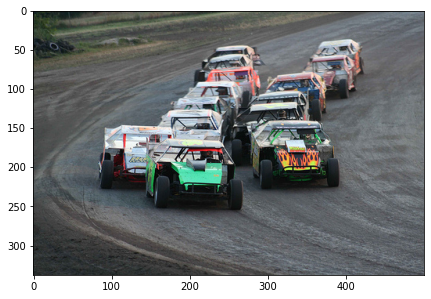

In [4]:
#Visualise the images present in the dataset

plt.figure(figsize=[7, 7])
plt.imshow(mpimg.imread(all_imgs[27]))
plt.show()

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):

    with open(filename, 'r') as file_obj:
        text = list(filter(None, (line.rstrip() for line in file_obj)))
    file_obj.close()

    return text

doc = load_doc(caption_file)
print(doc[22:28])

['1007129816_e794419615.jpg,A man wears an orange hat and glasses .', '1007129816_e794419615.jpg,A man with gauges and glasses is wearing a Blitz hat .', '1007129816_e794419615.jpg,A man with glasses is wearing a beer can crocheted hat .', '1007129816_e794419615.jpg,The man with pierced ears is wearing glasses and an orange hat .', '1007320043_627395c3d8.jpg,A child playing on a rope net .', '1007320043_627395c3d8.jpg,A little girl climbing on red roping .']


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [6]:
## Fetching the first index of the doc object before creating the dataframe

print(doc[1])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
## Store all the image id here
all_img_id = [i.split(',')[0] for i in doc[1:]]

## Store all the image path here
all_img_vector = [os.path.join(img_dir,i.split(',')[0]) for i in doc[1:]]

## Store all the captions here
annotations = [i.split(',')[1] for i in doc[1:]]

Creating the dataframe summarizing the image, path & captions as a dataframe

In [8]:
pd.set_option('display.max_colwidth', 100)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])
df.head(8)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,flickr8k/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,flickr8k/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,flickr8k/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .


In [9]:
## Checking if any feature has null

df.isnull().sum()

ID          0
Path        0
Captions    0
dtype: int64

In [10]:
## Checking the information of the dataset created above.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


#### As expected, we got 40455 samples in our dataset created above

In [11]:
## Create a list which contains all the captions, add the <start> & <end> token to all those captions as well

annotations = df.Captions.apply(lambda x : '<start> ' + x + ' <end>').to_list()

## Create a list which contains all the path to the images
all_img_path = df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
#Create the vocabulary & the counter for the captions

vocabulary = []
for caption in df.Captions.values :
    vocabulary.extend(caption.split())

val_count = Counter(vocabulary)
val_count

Counter({'A': 21480,
         'child': 1449,
         'in': 18170,
         'a': 38716,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1870,
         'entry': 1,
         'way': 48,
         '.': 34205,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         'spots': 28,
         'staring'

In [14]:
print(f"Vocabulary Size : {len(set(vocabulary))}")
print(f"Top 30 words : {val_count.most_common(30)}")

Vocabulary Size : 9536
Top 30 words : [('a', 38716), ('.', 34205), ('A', 21480), ('in', 18170), ('the', 14587), ('on', 10354), ('is', 9069), ('and', 8057), ('dog', 7804), ('with', 7303), ('man', 6727), ('of', 6495), ('Two', 3962), ('white', 3646), ('black', 3491), ('boy', 3395), ('are', 3364), ('girl', 3174), ('woman', 3146), ('to', 3005), ('The', 2919), ('wearing', 2916), ('at', 2809), ('water', 2671), ('red', 2542), ('young', 2411), ('people', 2397), ('brown', 2383), ('his', 2255), ('blue', 2116)]


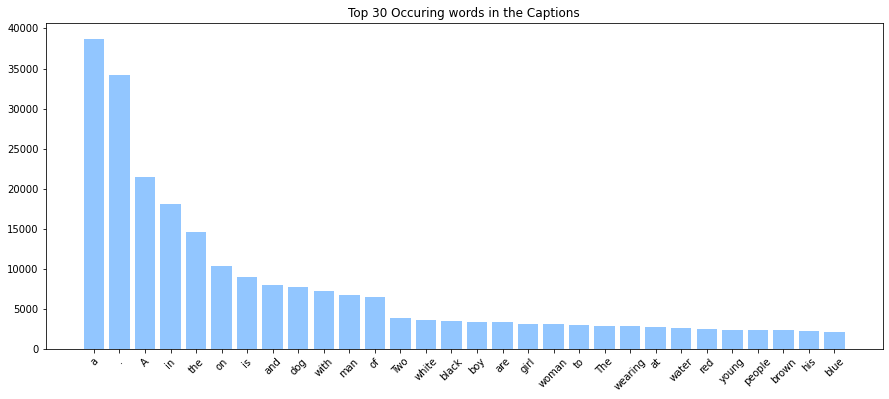

In [15]:
## Visualise the top 30 occuring words in the captions

def plot_for_words(word_counter) :
    plt.figure(figsize = (15, 6))
    plt.style.use('seaborn-pastel')
    plt.title('Top 30 Occuring words in the Captions')
    plt.xticks(rotation=45)
    plt.bar(*zip(*word_counter))
    plt.show()

plot_for_words(val_count.most_common(30))

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

#### Create the tokenizer

In [16]:
## We will take top 5000 words out of the vocabulary of size 9536

word_count = 5000

filter_str = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = word_count, filters = filter_str, oov_token="<UNK>")
tokenizer.fit_on_texts(annotations)
text_seq = tokenizer.texts_to_sequences(annotations)

print('text_seq : ' ,text_seq[23:28], '\n')
print('annotations : ' , annotations[23:28])

text_seq :  [[3, 2, 12, 11, 264, 8, 22, 2, 752, 824, 1, 99, 4], [3, 6, 12, 11, 2370, 560, 8, 22, 264, 9, 29, 90, 99, 4], [3, 2, 44, 35, 7, 2, 214, 621, 4], [3, 2, 39, 20, 116, 7, 27, 3972, 4], [3, 2, 39, 20, 5, 89, 248, 2, 214, 331, 24, 6, 118, 4]] 

annotations :  ['<start> A man with glasses is wearing a beer can crocheted hat . <end>', '<start> The man with pierced ears is wearing glasses and an orange hat . <end>', '<start> A child playing on a rope net . <end>', '<start> A little girl climbing on red roping . <end>', '<start> A little girl in pink climbs a rope bridge at the park . <end>']


#### Create word-to-index and index-to-word mappings.

In [17]:
word_to_indx = tokenizer.word_index
indx_to_word = tokenizer.index_word

In [18]:
## Adding PADDING

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

#### Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

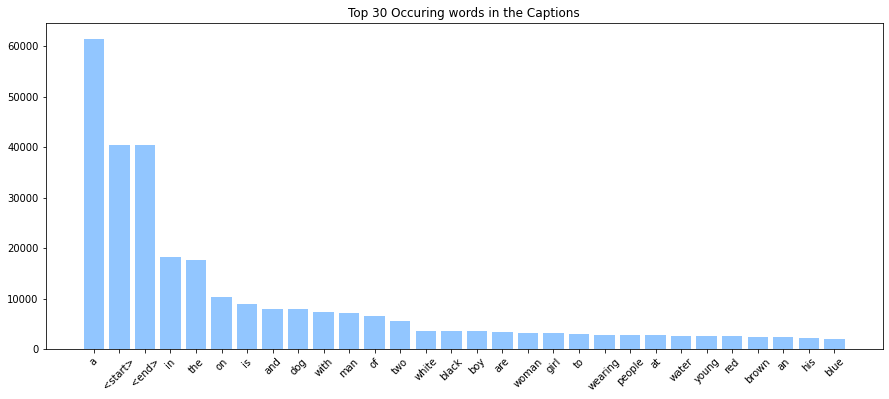

In [19]:
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_for_words(sort_word_by_count[:30])

#### Pad each vector to the max_length of the captions ^ store it to a vairable

In [20]:
max_sequence_len = max(len(t) for t in text_seq)
print(f'Max Sequence Length of the Texts is: {max_sequence_len}')

Max Sequence Length of the Texts is: 35


In [21]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(text_seq, padding='post', maxlen=max_sequence_len)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


#### Write your code here to create the dataset consisting of image paths

In [22]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [23]:
## Check the preprocessing Logic

print(f'Image size before preprocessing: {mpimg.imread(all_img_vector[0]).shape}')
print(f'Image size after preprocessing: {load_image(all_img_vector[0])[0].shape}')

Image size before preprocessing: (500, 375, 3)
Image size after preprocessing: (299, 299, 3)


2023-07-23 06:18:57.934160: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-23 06:18:57.934223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22845 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [24]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

unique_img_vector = sorted(set(all_img_vector))
img_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)

In [25]:
img_dataset = img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .batch(64)
img_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [26]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

## Write code here to get the input of the image_model
new_input = image_model.input

## Write code here to get the output of the image_model
hidden_layer = image_model.layers[-1].output

## Build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [27]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [28]:
## The tqdm library is widely used in data science, machine learning, and other areas where tracking the progress of
## time-consuming operations is important.

from tqdm import tqdm

In [29]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

for img, path in tqdm(img_dataset) :
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path) :
        path_of_features = p.numpy().decode('utf-8')
        np.save(path_of_features, bf.numpy())

100%|██████████| 127/127 [00:30<00:00,  4.21it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


#### Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

In [54]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, train_size=0.75, random_state=42)

In [55]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 30341
Testing data for images: 10114
Training data for Captions: 30341
Testing data for Captions: 10114


#### Create a function which maps the image path to their feature.
#### This function will take the image_path & caption and return it's feature & respective caption.

In [56]:
## Write your code here to extract the features from the dictionary stored earlier

def map_func(image, caption):
    img_tensor = np.load(image.decode('utf-8')+'.npy')
    return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [57]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image, caption,batch_size = 64,buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [58]:
batch_size = 64
train_dataset=gen_dataset(path_train, cap_train, batch_size)
test_dataset=gen_dataset(path_test, cap_test, batch_size)

In [59]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [60]:
embedding_dim = 256
units = 512

## Top 5,000 words +1
vocab_size = 5001

train_num_steps = len(path_train) // batch_size
test_num_steps = len(path_test) // batch_size

print(train_num_steps)
print(test_num_steps)

474
158


### Encoder

In [61]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.4)

    def call(self, features):
        features = self.dense(features)
        features = tf.nn.relu(features)

        return features

In [62]:
encoder = Encoder(embedding_dim)

### Attention model

In [41]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units

    def call(self, features, hidden):

        ## Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        ## Build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        ## Extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)

        ## Shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features

        ## Reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Decoder

In [63]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units

        ## Initialise your Attention model with units
        self.attention = Attention_model(self.units)

        ## Build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero = False)

        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

        ## Build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)

        ## Adding Dropout layer
     #   self.dropout = tf.keras.layers.Dropout(0.5)


    def call(self,x,features, hidden):
        ## Create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)

        ## Embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)

        ## Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1)

        ## Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)

        ## Shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        ## shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output,state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [64]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [65]:
features=encoder(sample_img_batch)

hidden = decoder.reset_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [66]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [67]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [68]:
checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [69]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [70]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:

        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [71]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
    #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            predicted_id = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_id, 1)

    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [72]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [73]:
from keras.callbacks import EarlyStopping

In [74]:
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 40

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/40 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.371, & test loss is 1.989
Time taken for 1 epoch 161.6636483669281 sec

Test loss has been reduced from 100.000 to 1.989


  2%|▎         | 1/40 [02:42<1:45:22, 162.11s/it]

For epoch: 2, the train loss is 1.065, & test loss is 1.966
Time taken for 1 epoch 63.32487082481384 sec

Test loss has been reduced from 1.989 to 1.966


  8%|▊         | 3/40 [04:50<53:02, 86.01s/it]   

For epoch: 3, the train loss is 0.966, & test loss is 1.989
Time taken for 1 epoch 64.30479097366333 sec



 10%|█         | 4/40 [05:55<46:43, 77.89s/it]

For epoch: 4, the train loss is 0.897, & test loss is 2.046
Time taken for 1 epoch 65.42874455451965 sec



 12%|█▎        | 5/40 [07:00<42:47, 73.36s/it]

For epoch: 5, the train loss is 0.842, & test loss is 2.046
Time taken for 1 epoch 65.32951092720032 sec



 15%|█▌        | 6/40 [08:07<40:15, 71.04s/it]

For epoch: 6, the train loss is 0.793, & test loss is 2.151
Time taken for 1 epoch 66.5390031337738 sec



 18%|█▊        | 7/40 [09:11<37:45, 68.64s/it]

For epoch: 7, the train loss is 0.748, & test loss is 2.185
Time taken for 1 epoch 63.6984601020813 sec



 20%|██        | 8/40 [10:16<36:02, 67.59s/it]

For epoch: 8, the train loss is 0.706, & test loss is 2.159
Time taken for 1 epoch 65.3389904499054 sec



 22%|██▎       | 9/40 [11:21<34:25, 66.63s/it]

For epoch: 9, the train loss is 0.665, & test loss is 2.261
Time taken for 1 epoch 64.52489471435547 sec



 25%|██▌       | 10/40 [12:26<33:04, 66.16s/it]

For epoch: 10, the train loss is 0.628, & test loss is 2.294
Time taken for 1 epoch 65.10536050796509 sec



 28%|██▊       | 11/40 [13:31<31:53, 65.99s/it]

For epoch: 11, the train loss is 0.594, & test loss is 2.314
Time taken for 1 epoch 65.61118245124817 sec



 30%|███       | 12/40 [14:36<30:33, 65.47s/it]

For epoch: 12, the train loss is 0.562, & test loss is 2.440
Time taken for 1 epoch 64.27386808395386 sec



 32%|███▎      | 13/40 [15:39<29:14, 64.98s/it]

For epoch: 13, the train loss is 0.533, & test loss is 2.490
Time taken for 1 epoch 63.84641075134277 sec



 35%|███▌      | 14/40 [16:45<28:11, 65.04s/it]

For epoch: 14, the train loss is 0.503, & test loss is 2.610
Time taken for 1 epoch 65.18701004981995 sec



 38%|███▊      | 15/40 [17:51<27:18, 65.54s/it]

For epoch: 15, the train loss is 0.478, & test loss is 2.659
Time taken for 1 epoch 66.69169926643372 sec



 40%|████      | 16/40 [18:58<26:18, 65.76s/it]

For epoch: 16, the train loss is 0.454, & test loss is 2.748
Time taken for 1 epoch 66.27552151679993 sec



 42%|████▎     | 17/40 [20:04<25:15, 65.90s/it]

For epoch: 17, the train loss is 0.431, & test loss is 2.828
Time taken for 1 epoch 66.21881175041199 sec



 45%|████▌     | 18/40 [21:09<24:02, 65.56s/it]

For epoch: 18, the train loss is 0.412, & test loss is 2.934
Time taken for 1 epoch 64.76710844039917 sec



 48%|████▊     | 19/40 [22:12<22:42, 64.90s/it]

For epoch: 19, the train loss is 0.391, & test loss is 3.015
Time taken for 1 epoch 63.36782622337341 sec



 50%|█████     | 20/40 [23:19<21:49, 65.46s/it]

For epoch: 20, the train loss is 0.376, & test loss is 3.115
Time taken for 1 epoch 66.75449919700623 sec



 52%|█████▎    | 21/40 [24:24<20:40, 65.28s/it]

For epoch: 21, the train loss is 0.360, & test loss is 3.200
Time taken for 1 epoch 64.87381100654602 sec



 55%|█████▌    | 22/40 [25:31<19:49, 66.07s/it]

For epoch: 22, the train loss is 0.348, & test loss is 3.256
Time taken for 1 epoch 67.90139889717102 sec



 57%|█████▊    | 23/40 [26:38<18:44, 66.17s/it]

For epoch: 23, the train loss is 0.332, & test loss is 3.342
Time taken for 1 epoch 66.41125106811523 sec



 60%|██████    | 24/40 [27:43<17:31, 65.72s/it]

For epoch: 24, the train loss is 0.318, & test loss is 3.447
Time taken for 1 epoch 64.64570665359497 sec



 62%|██████▎   | 25/40 [28:48<16:22, 65.53s/it]

For epoch: 25, the train loss is 0.309, & test loss is 3.517
Time taken for 1 epoch 65.09359765052795 sec



 65%|██████▌   | 26/40 [29:52<15:10, 65.07s/it]

For epoch: 26, the train loss is 0.297, & test loss is 3.647
Time taken for 1 epoch 63.992770195007324 sec



 68%|██████▊   | 27/40 [30:57<14:07, 65.19s/it]

For epoch: 27, the train loss is 0.288, & test loss is 3.711
Time taken for 1 epoch 65.47906446456909 sec



 70%|███████   | 28/40 [32:03<13:03, 65.29s/it]

For epoch: 28, the train loss is 0.278, & test loss is 3.754
Time taken for 1 epoch 65.52153897285461 sec



 72%|███████▎  | 29/40 [33:08<11:56, 65.18s/it]

For epoch: 29, the train loss is 0.271, & test loss is 3.845
Time taken for 1 epoch 64.90190625190735 sec



 75%|███████▌  | 30/40 [34:12<10:50, 65.08s/it]

For epoch: 30, the train loss is 0.261, & test loss is 3.911
Time taken for 1 epoch 64.86177825927734 sec



 78%|███████▊  | 31/40 [35:17<09:45, 65.06s/it]

For epoch: 31, the train loss is 0.255, & test loss is 4.015
Time taken for 1 epoch 65.0128185749054 sec



 80%|████████  | 32/40 [36:24<08:44, 65.61s/it]

For epoch: 32, the train loss is 0.247, & test loss is 4.059
Time taken for 1 epoch 66.86995768547058 sec



 82%|████████▎ | 33/40 [37:28<07:36, 65.15s/it]

For epoch: 33, the train loss is 0.247, & test loss is 4.121
Time taken for 1 epoch 64.06795907020569 sec



 85%|████████▌ | 34/40 [38:33<06:30, 65.02s/it]

For epoch: 34, the train loss is 0.235, & test loss is 4.196
Time taken for 1 epoch 64.72288966178894 sec



 88%|████████▊ | 35/40 [39:37<05:23, 64.74s/it]

For epoch: 35, the train loss is 0.229, & test loss is 4.295
Time taken for 1 epoch 64.09346199035645 sec



 90%|█████████ | 36/40 [40:43<04:19, 64.93s/it]

For epoch: 36, the train loss is 0.224, & test loss is 4.334
Time taken for 1 epoch 65.36941766738892 sec



 92%|█████████▎| 37/40 [41:48<03:15, 65.20s/it]

For epoch: 37, the train loss is 0.214, & test loss is 4.417
Time taken for 1 epoch 65.84185433387756 sec



 95%|█████████▌| 38/40 [42:53<02:10, 65.11s/it]

For epoch: 38, the train loss is 0.215, & test loss is 4.456
Time taken for 1 epoch 64.89027404785156 sec



 98%|█████████▊| 39/40 [44:00<01:05, 65.49s/it]

For epoch: 39, the train loss is 0.212, & test loss is 4.524
Time taken for 1 epoch 66.36284470558167 sec



100%|██████████| 40/40 [45:06<00:00, 67.65s/it]

For epoch: 40, the train loss is 0.210, & test loss is 4.555
Time taken for 1 epoch 65.9838719367981 sec



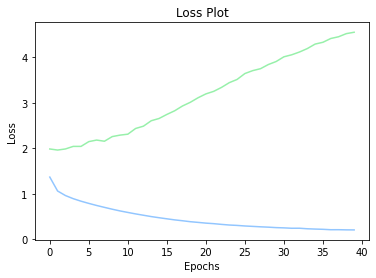

In [75]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [76]:
attention_features_shape = 64
max_length = max(len(t) for t in text_seq)

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    
    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)
    
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.random.categorical(predictions, 1)[0,0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [77]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [96]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

### Evaluating Beam Search

a dog dog while his tongue out of a dirt



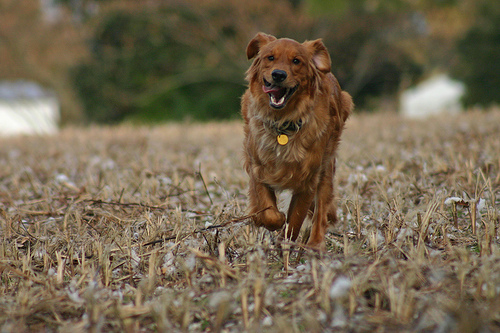

In [90]:
from PIL import Image
test_img = "./flickr8k/Images/69189650_6687da7280.jpg"

captions=beam_evaluate(test_img)
print(captions + '\n')
Image.open(test_img)

In [82]:
from nltk.translate.bleu_score import sentence_bleu

In [83]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [97]:
def test_caption_generation(img_test):


    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join(
        tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]
    )

    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)

    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))
    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")

    plot_attmap(result, attention_plot, test_image)


    Image.open(test_image)

Real Caption: a young boy in blue is chasing a young girl sitting in a play car
Prediction Caption: a little girl out of two black sunglasses drives a woman in a stripe is pushing toddler while a little girl with a boy stands in the street is sitting on a game

BELU score: 
Individual 1-gram: 27.27272727272727
Individual 2-gram: 3.125
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


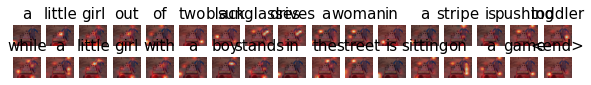

In [98]:
test_caption_generation(path_test)

### Evaluating the data

In [99]:
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    newsize = (800, 800)
    im = Image.open(openImg).resize(newsize)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))
    
    return im

Prediction Caption: skateboarders in the side of a white building

800 800


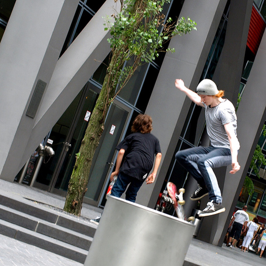

In [100]:
Prediction_Unknown_data(path_test[32])